# <center><font color='navy' size=6> Sales Forecasting Using LR</font></center>
---

In [119]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime
import statsmodels.tsa.api as smt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

## Load and View the Data
---

The first step is to load the data and transform it into a structure that we will then use for our models.

In [120]:
def load_data():
    DATAPATH = 'data/train.csv'
    
    return pd.read_csv(DATAPATH)

In [121]:
data = load_data()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null object
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In its raw form, each row of data represents a single day of sales at one of ten stores. Our goal is to predict ***monthly sales***, so we will first consolidate all stores and days into total monthly sales.

In [122]:
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In our new data frame, each row now represents total sales in a given month across all stores.

In [123]:
def monthly_sales(data):    
    data = data.copy()     
    
    # Drop the day indicator from the date column    
    data.date = data.date.apply(lambda x: str(x)[:-3])    
    
    # Sum sales per month    
    data = data.groupby('date')['sales'].sum().reset_index()    
    data.date = pd.to_datetime(data.date)  
    data.to_csv('data/monthly_data.csv')     
    return data

monthly_data = monthly_sales(data)
monthly_data.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


## Exploratory Data Analysis
---

In [124]:
# Duration of dataset
def sales_duration(data):
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'days')
    print(number_of_years, 'years')
    
sales_duration(data)

1825 days
5.0 years


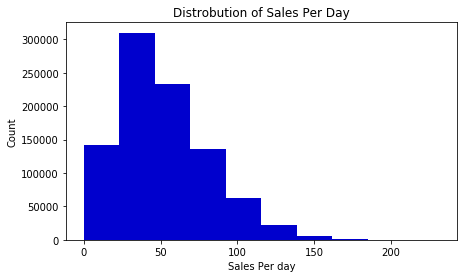

In [125]:
def sales_per_day():
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(data.sales, color='mediumblue')
    
    ax.set(xlabel = "Sales Per day",
           ylabel = "Count",
           title = "Distrobution of Sales Per Day")
    
sales_per_day()

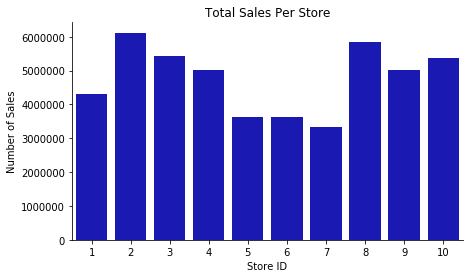

In [126]:
def sales_per_store():
    by_store = data.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(7,4))
    sns.barplot(by_store.store, by_store.sales, color='mediumblue')
    
    ax.set(xlabel = "Store ID",
           ylabel = "Number of Sales",
           title = "Total Sales Per Store")
    
    sns.despine()
    
sales_per_store()

In [127]:
# Average monthly sales

# Overall
avg_monthly_sales = monthly_data.sales.mean()
print(f"Overall average monthly sales: ${avg_monthly_sales}")

# Last 12 months (this will be the forecasted sales)
avg_monthly_sales_12month = monthly_data.sales[-12:].mean()
print(f"Last 12 months average monthly sales: ${avg_monthly_sales_12month}")

Overall average monthly sales: $795075.2
Last 12 months average monthly sales: $894478.3333333334


## Determining Stationarity
---

In [128]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()

If we plot the total monthly sales over time, we see that average monthly sales increase over time, which means that our data is not stationary.

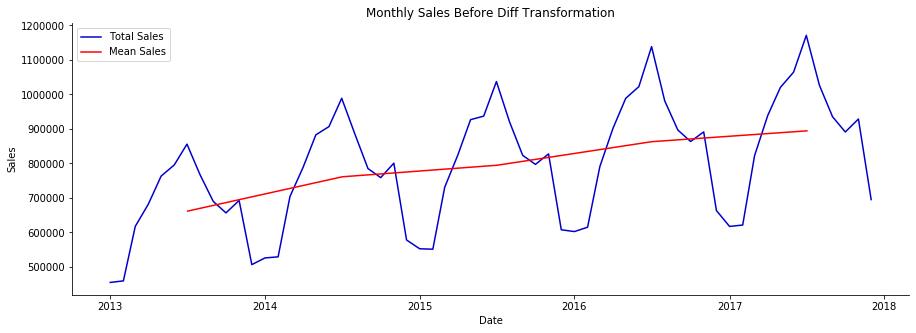

In [129]:
time_plot(monthly_data, 'date', 'sales', 'Monthly Sales Before Diff Transformation')

To make it stationary, we will calculate the difference between sales in each month and add this into our data frame as a new column.

In [130]:
def get_diff(data):
    data['sales_diff'] = data.sales.diff()  # search
    data = data.dropna()
    
    data.to_csv('data/stationary_df.csv')
    return data

In [131]:
stationary_df = get_diff(monthly_data)
stationary_df.head()

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


Now that our data represent monthly sales and we have transformed it to be stationary, we will set up the data for our different model types. To do this, we will define two different structures: one will be used for ARIMA modeling and the other will be used for the rest of the models.

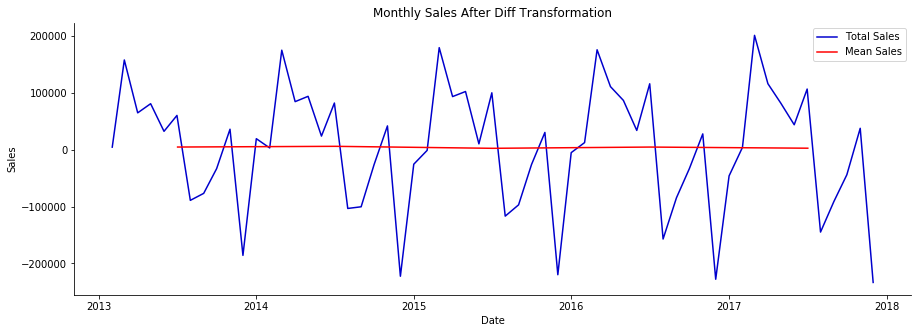

In [132]:
time_plot(stationary_df, 'date', 'sales_diff', 'Monthly Sales After Diff Transformation')

## Observing Lags
---

For our Arima model, we will need only a datetime index and the dependent variable (diff in sales) columns. For our other models, we will create a new data frame where each feature represents a previous month’s sales.

To determine how many months to include in our feature set, we will observe the autocorrelation and partial autocorrelation plots. This way, we can keep a consistent look-back period for our ARIMA and regressive models.

/Users/yesihernandez/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


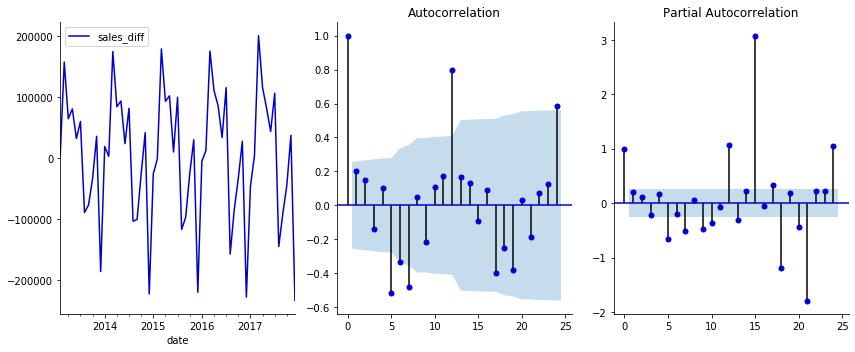

In [133]:
def plots(data, lags=None):
    
    # Convert dataframe to datetime index
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(12, 5), color='mediumblue')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()

plots(stationary_df, lags=24);

Based on the above, we will choose our look-back period to be 12 months. We will, therefore, generate a data frame that has 13 columns, 1 column for each of the 12 months and the column for our dependent variable, difference in sales.

## Preparing Dataset Modeling
---

### Regressive Modeling

In [134]:
#create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    supervised_df.to_csv('data/model_df.csv', index=False)
    
    return supervised_df

In [135]:
model_df = generate_supervised(stationary_df)
model_df.head()

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


### ARIMA Modeling

In [136]:
def generate_arima_data(data):
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    dt_data.to_csv('data/arima_df.csv')
    
    return dt_data

In [137]:
datetime_df = generate_arima_data(stationary_df)
datetime_df.head()

,sales_diff
date,
2013-02-01,4513.0
2013-03-01,157965.0
2013-04-01,64892.0
2013-05-01,80968.0
2013-06-01,32355.0


Now we have two separate data structures, our Arima structure that includes a datetime index and our supervised structure that includes lags as features.

## Modeling
---

To create and assess all of our models, we use a series of helper functions that perform the following functions.

1. **Train test split**: we separate our data so that the last 12 months are part of the test set and the rest of the data is used to train our model
2. **Scale the data**: using a min-max scaler, we will scale the data so that all of our variables fall within the range of -1 to 1
3. **Reverse scaling**: After running our models, we will use this helper function to reverse the scaling of step 2
4. **Create a predictions data frame**: generate a data frame that includes the actual sales captured in our test set and the predicted results from our model so that we can quantify our success
5. **Score the models**: this helper function will save the root mean squared error (RMSE) and mean absolute error (MAE) of our predictions to compare performance of our five models

### Train Test Split

In [138]:
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    
    return train, test

train, test = tts(model_df)

In [139]:
train.shape

(35, 13)

In [140]:
test.shape

(12, 13)

### Scale the data

In [141]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [142]:
y_train.shape

(35,)

### Reverse scaling

In [143]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [144]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('data/train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

### Create a predictions data frame

In [145]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

### Score the models

In [146]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [153]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()

In [154]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

## Linear Regression
---

The output below shows the predictions (red) overlaid on top of the actual sales (blue) for each of the regressive models. While the results look similar, the nuanced differences equate to a few thousand dollars in sales, 

RMSE: 16221.040790693221
MAE: 12433.0
R2 Score: 0.9907155879704752


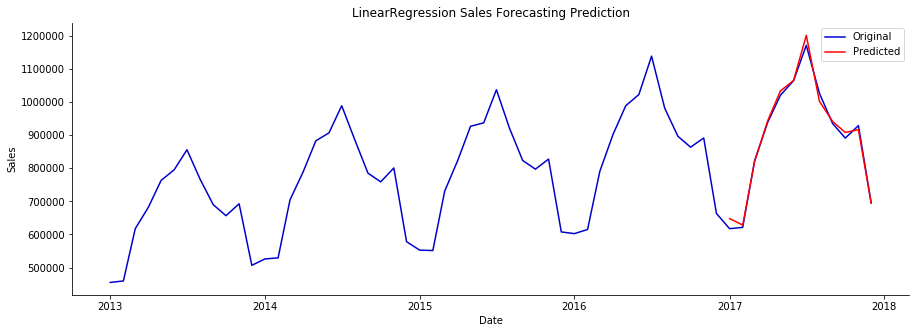

In [155]:
run_model(train, test, LinearRegression(), 'LinearRegression')